In [11]:
import pandas as pd

In [12]:
data = pd.read_excel('HEROdata2.xlsx')
data.head()

,Number of ports,Number of nets,Number of cells,Number of combinational cells,Number of sequential cells,Number of macros/black boxes,Number of buf/inv,Number of references,Combinational area,Buf/Inv area,...,Combinational Internal Power,Combinational Switching Power,Combinational Leakage Power,Combinational Total Power,Total Internal Power,Total Switching Power,Total Leakage Power,Total Total Power,Label,Circuit
0,26623,198177,172368,164960,6850,0,19504,22,173046.832023,10376.128102,...,18253.0,32696.0,5135800.0,56082.0,45560.0,38947.0,5677500.0,90182.0,'Trojan Free','AES'
1,27289,198776,172486,164991,6934,0,19504,2,173081.678022,10376.128102,...,18260.0,32707.0,5136600.0,56101.0,45820.0,38963.0,5685000.0,90465.0,'Trojan Infected','AES-T100'
2,27545,198893,172468,164973,6934,0,19504,2,173066.250022,10376.128102,...,18257.0,32707.0,5136200.0,56097.0,45851.0,38965.0,5685000.0,90498.0,'Trojan Infected','AES-T200'
3,28033,198562,172369,164960,6850,0,19504,1,173046.832023,10376.128102,...,18250.0,32693.0,5135800.0,56076.0,45553.0,38942.0,5677500.0,90170.0,'Trojan Infected','AES-T300'
4,27325,199431,172899,165330,7007,0,19518,3,173451.418025,10385.704102,...,18286.0,32727.0,5144100.0,56154.0,45725.0,38982.0,5701100.0,90405.0,'Trojan Infected','AES-T400'


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns


In [20]:
def create_numerics(data):
    # Get nominal columns
    nominal_cols = data.select_dtypes(include='object').columns.tolist()

    # Turn nominal to numeric
    for nom in nominal_cols:
        enc = LabelEncoder()
        enc.fit(data[nom])
        data[nom] = enc.transform(data[nom])

    return data

    
def prepare_data():
    data = pd.read_excel("HEROdata2.xlsx")
    data = data.dropna()
    
    trojan_free = data.loc[data['Label']=="'Trojan Free'"].reset_index()    
    
    # balance the ratio between trojan free and infected of the same circuit category
    for i in range(len(trojan_free)):
        category_substring = trojan_free['Circuit'][i].replace("'", '')
        circuit_group = data[data['Circuit'].str.contains(category_substring)]

        df1 = circuit_group.iloc[0:1]

        if len(circuit_group) > 1:
            df1 = df1.reset_index(drop=True)  # Reset the index of df1
            data = data.append([df1] * (len(circuit_group) - 1), ignore_index=True)

    
    data.drop(columns=['Circuit'], inplace=True)

    data = create_numerics(data)
    
    data = shuffle(data, random_state=42)

    # Create correlation matrix
    corr_matrix = data.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),
                                      k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    # Drop features
    data = data.drop(data[to_drop], axis=1)
    
    y = pd.DataFrame(data["Label"]).values
    x = data.drop(["Label"], axis=1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    x = scaler.fit_transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)
    
    """
    # plot the correlated features
    sns.heatmap(
        corr_matrix,
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    plt.title("Features correlation")
    plt.show()
    """
    return(x_train, x_test, y_train, y_test)

In [15]:
pip install np_utils

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
import time
import sys
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense


In [21]:
def logistic_regression():
    """
    This function performs classification with logistic regression.
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))

    clf = LogisticRegression(random_state=0, solver='liblinear', max_iter=300,
                             multi_class='ovr')
    start = time.time()
    clf.fit(train_x, train_y)
    end = time.time()
    
    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### LR ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))

    return(time_, accuracy)


In [18]:
logistic_regression()

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
def random_forest():
    """
    This function performs classification with random forest.
    """
    train_x, test_x, train_y, test_y = prepare_data()
    train_y = train_y.reshape((train_y.shape[0], ))
        
    clf = RandomForestClassifier(n_estimators=5, max_depth=5, random_state=1)
    
    start = time.time()
    clf.fit(train_x, train_y)    
    end = time.time()

    y_pred = clf.predict(test_x)

    time_ = end - start
    accuracy = 100 * accuracy_score(test_y, y_pred)

    print("### RF ###\n")
    print("Training lasted %.2f seconds" % time_)
    print("Accuracy = %.2f" % (accuracy))
    print("F1-score = ",f1_score(test_y, y_pred, average='macro')*100)
        
    
    importance = clf.feature_importances_
    
    # summarize feature importance
    for i,v in enumerate(importance):
    	print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.xlabel('Features')
    plt.ylabel('Feature importance factor')
    plt.title('Features importance')
    plt.show()
    
    return(time_, accuracy)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_11220\3260764768.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append([df1]*(len(circuit_group)-1), ignore_index=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_11220\3260764768.py:41: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  k=1).astype(np.bool))


### RF ###

Training lasted 0.01 seconds
Accuracy = 99.01
F1-score =  98.78878604406435
Feature: 0, Score: 0.06552
Feature: 1, Score: 0.24553
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.47869
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.01822
Feature: 6, Score: 0.17742
Feature: 7, Score: 0.00718
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.00000
Feature: 19, Score: 0.00000
Feature: 20, Score: 0.00000
Feature: 21, Score: 0.00227
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00319
Feature: 24, Score: 0.00196


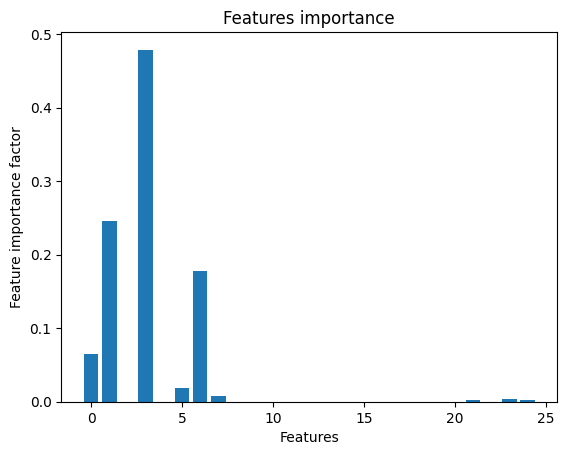

(0.013088464736938477, 99.00881057268722)

In [ ]:
random_forest()